<div style="background: #f0f8ff; padding: 20px; border-left: 5px solid #3498db; border-radius: 10px; font-family: 'Segoe UI', sans-serif; text-align: center;">

<h2 style="color: #2c3e50; margin-bottom: 15px;">
  📘 Báo cáo phương pháp và kế hoạch triển khai chiến lược đầu tư
</h2>

<p style="font-size: 16px; line-height: 1.6; color: #34495e; display: inline-block; text-align: justify; max-width: 800px;">
  <strong>Mục tiêu:</strong> Xây dựng một chiến lược phân bổ vốn linh hoạt theo từng tháng (dưới dạng ma trận trọng số x4) nhằm tối đa hóa lợi nhuận đã điều chỉnh theo rủi ro cho danh mục 4 tài sản trong n tháng.
</p>

</div>


In [1]:
# !pip install arch pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
import os
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
import pmdarima as pm
from arch.univariate.base import ARCHModelResult

import copy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 1. Load Cleaned Dataset
Cleaned dataset là dataset BTC cung cấp đã trải qua làm sạch và tiền xử lý

In [3]:
# Truy cập ra ngoài thư mục notebooks, rồi vào data/
import os
dataset_path = os.path.join('..', 'data', 'cleaned_data.csv')

# Load data
data = pd.read_csv(dataset_path, encoding='utf-8', parse_dates=['Time'])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Time                    390 non-null    datetime64[ns]
 1   Crypto                  390 non-null    float64       
 2   Buying_Price_of_Nexus   390 non-null    float64       
 3   Selling_Price_of_Nexus  390 non-null    float64       
 4   Price_of_Stock          390 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 15.4 KB


In [5]:
data.head()

,Time,Crypto,Buying_Price_of_Nexus,Selling_Price_of_Nexus,Price_of_Stock
0,2024-05-20,4174.950000,1270.30,1272.56,113.456685
1,2024-05-21,4340.316717,1272.75,1277.70,114.961755
2,2024-05-22,4331.770000,1285.15,1287.88,110.453726
3,2024-05-23,4360.513317,1295.80,1297.22,110.921833
4,2024-05-24,4354.308333,1292.90,1297.53,109.518120


# 2. Chuẩn bị và Biến đổi Dữ liệu (Transform)

Để đơn giản mô hình và có nâng cao tính tái sử dụng mã nguồn, nhóm sẽ đặt ra các giả định sau:

- Ước lược chi phí giao dịch kim loại Nexus là trung bình độ lệch giữa giá bán và giá mua. 
- Tạo cột `Average_Price_of_Nexus` là trung bình của `Buying_Price_of_Nexus` và `Selling_Price_of_Nexus`.

Điều này là hợp lý vì giá bán và giá mua luôn theo sát nhau, thể hiện qua hệ số tương quan đạt 99.95%

In [6]:
correlation = data['Buying_Price_of_Nexus'].corr(data['Selling_Price_of_Nexus'])
print(f"Hệ số tương quan giữa giá mua và giá bán là: {correlation:.4f}")

Hệ số tương quan giữa giá mua và giá bán là: 0.9995


In [7]:
price_buy = data['Buying_Price_of_Nexus']
price_sell = data['Selling_Price_of_Nexus']
price_avg = (price_buy + price_sell) / 2

avg_transaction_cost_nexus = ((price_sell - price_buy) / price_avg).mean()

# Tính phí giao dịch trung bình toàn thị trường
print(f"Vậy phí giao dịch của nexus trung bình là {avg_transaction_cost_nexus}")

Vậy phí giao dịch của nexus trung bình là 0.003101658626783291


In [8]:
# Tạo cột mới là trung bình và xóa 2 cột cũ
data["Average_Price_of_Nexus"] = (data["Buying_Price_of_Nexus"] + data["Selling_Price_of_Nexus"]) / 2
data.drop(["Buying_Price_of_Nexus", "Selling_Price_of_Nexus"], axis=1, inplace=True)

# Xem kết quả
data.head()

,Time,Crypto,Price_of_Stock,Average_Price_of_Nexus
0,2024-05-20,4174.950000,113.456685,1271.430
1,2024-05-21,4340.316717,114.961755,1275.225
2,2024-05-22,4331.770000,110.453726,1286.515
3,2024-05-23,4360.513317,110.921833,1296.510
4,2024-05-24,4354.308333,109.518120,1295.215


## 2.1 Tính Tỷ suất sinh lợi Logarit Hàng ngày (Daily Log Returns)

Mô hình Markowitz không hoạt động trên giá mà trên tỷ suất sinh lợi (returns). Vì vậy, bước đầu tiên và quan trọng nhất là chuyển đổi dữ liệu giá thành tỷ suất sinh lợi hàng ngày.

**Tính tỷ suất sinh lợi logarit hàng ngày (Daily Log Returns)**:
Thay vì lợi nhuận phần trăm đơn giản, ta nên dùng lợi nhuận logarit.

* Công thức: $r_t = \log(P_t) - \log(P_{t-1})$
* **Lợi ích**: Gần với phân phối chuẩn hơn, dễ cộng dồn theo thời gian.

Kết quả là chuỗi tỷ suất sinh lợi hàng ngày cho 3 tài sản: Tiết kiệm, Crypto, Cổ phiếu, Nexus.

In [9]:
# Tính log return hàng ngày
daily_log_returns = np.log(data.drop(columns='Time') / data.drop(columns='Time').shift(1)).dropna()

# Đổi tên cột cho cho đúng bản chất 
daily_log_returns = daily_log_returns.rename(columns={
    'Crypto': 'Crypto_Returns',
    'Price_of_Stock': 'Stocks_Returns',
    'Average_Price_of_Nexus': 'Nexus_Returns'
})

# Thêm lại cột thời gian tương ứng
daily_log_returns = daily_log_returns.assign(Time=data['Time'].iloc[1:].values)

In [10]:
daily_log_returns

,Crypto_Returns,Stocks_Returns,Nexus_Returns,Time
1,0.038845,0.013178,0.002980,2024-05-21
2,-0.001971,-0.040003,0.008814,2024-05-22
3,0.006614,0.004229,0.007739,2024-05-23
4,-0.001424,-0.012736,-0.000999,2024-05-24
5,-0.003510,0.000000,0.000000,2024-05-25
...,...,...,...,...
385,-0.003689,0.030113,0.005703,2025-06-09
386,0.008398,-0.015309,-0.002781,2025-06-10
387,0.026983,0.009929,0.001555,2025-06-11
388,0.003010,0.038140,-0.004197,2025-06-12


## 2.2 Phân chia Tập dữ liệu Huấn luyện và Kiểm tra

Đề bài yêu cầu xây dựng một giải pháp đầu tư cho khoảng thời gian một năm, trong khi bộ dữ liệu được cung cấp gồm 390 ngày. Một thách thức lớn là cân bằng giữa việc có đủ dữ liệu để kiểm tra (backtest) và có đủ dữ liệu để huấn luyện mô hình một cách hiệu quả.

Sau khi thử nghiệm, nhóm nhận thấy việc huấn luyện mô hình trên một khoảng thời gian dài (ví dụ: 10 tháng) không mang lại kết quả tốt, có thể do các xu hướng thị trường cũ không còn phù hợp với bối cảnh hiện tại.

Do đó, một quyết định chiến lược đã được đưa ra: sử dụng một cửa sổ huấn luyện ngắn hạn là **30 ngày** và dành phần lớn dữ liệu (**360 ngày**) cho việc kiểm tra.

**Lý do lựa chọn:**

* **Tập trung vào xu hướng gần nhất:** Việc chỉ sử dụng 30 ngày dữ liệu gần nhất giúp mô hình trở nên "nhạy bén" hơn với các động lực thị trường hiện tại, thay vì bị ảnh hưởng bởi các quy luật đã lỗi thời trong quá khứ.
* **Phù hợp với chu kỳ đầu tư:** Cửa sổ huấn luyện 30 ngày hoàn toàn tương thích với chu kỳ tái cân bằng danh mục hàng tháng, đảm bảo mô hình được huấn luyện trên một khoảng thời gian tương đương với tần suất ra quyết định.
* **Tối đa hóa thời gian kiểm tra:** Cách tiếp cận này cho phép kiểm chứng hiệu quả của chiến lược trên một khoảng thời gian dài gần một năm (360 ngày - tương đương 11 tháng 20 ngày), đáp ứng tốt nhất yêu cầu của đề bài. Kết quả sẽ được đánh giá dựa trên hiệu suất của 11 tháng trong tập kiểm tra này.

In [11]:
# Mỗi tháng ta sẽ dùng 30 ngày trước đó làm tập training
train_day = 30
test_day = len(daily_log_returns) - train_day
daily_log_returns_test = daily_log_returns[-test_day:]
daily_log_returns = daily_log_returns[0:train_day]

In [12]:
daily_log_returns_test

,Crypto_Returns,Stocks_Returns,Nexus_Returns,Time
31,0.037470,-0.024456,0.000354,2024-06-20
32,0.000326,0.033148,-0.000284,2024-06-21
33,0.042735,0.000000,0.000000,2024-06-22
34,-0.008213,0.000000,0.000000,2024-06-23
35,-0.007523,-0.033289,-0.007727,2024-06-24
...,...,...,...,...
385,-0.003689,0.030113,0.005703,2025-06-09
386,0.008398,-0.015309,-0.002781,2025-06-10
387,0.026983,0.009929,0.001555,2025-06-11
388,0.003010,0.038140,-0.004197,2025-06-12


In [13]:
daily_log_returns

,Crypto_Returns,Stocks_Returns,Nexus_Returns,Time
1,0.038845,0.013178,0.002980,2024-05-21
2,-0.001971,-0.040003,0.008814,2024-05-22
3,0.006614,0.004229,0.007739,2024-05-23
4,-0.001424,-0.012736,-0.000999,2024-05-24
5,-0.003510,0.000000,0.000000,2024-05-25
6,0.060135,0.000000,0.000000,2024-05-26
7,-0.002825,0.000404,-0.002404,2024-05-27
8,-0.002717,0.010600,-0.002953,2024-05-28
9,0.069379,0.017815,0.024528,2024-05-29
10,-0.069845,-0.023506,-0.008435,2024-05-30


## 2.3 Sử dụng Arima để ước lượng hệ số lợi nhuận kì vọng của mô hình Markovist

Tại sao dùng ARIMA cho trường hợp này:

- Ta đang muốn tìm tham số $\mu$ (vector lợi nhuận kì vọng) cho mô hình Markovist, với cách triển khai cổ điển ta sẽ lấy trung bình log returns của dữ liệu (ta dự đoán lợi nhuận kì vọng của tài sản bằng cách tính trung bình lợi nhuận quá khứ của tài sản tương ứng - Tuy nhiên cách này có thể không phù hợp cho môi trường tài chính, khi biến động ngắn hạng thường có xu hướng là 1 bước ngẫu nhiên).
- Thay vào đó ta sẽ sử dụng ARIMA (một mô hình thống kê truyền thống dự báo biến mục tiêu chỉ bằng lịch sử của chính biến mục tiêu). Vì giả thuyết đã đặt ra là chúng ta sẽ chỉ tái đầu tư vào mỗi đầu tháng mới, nên việc dùng Arima để dự đoán lợi nhuận trung bình của tài sản cho tháng tiếp theo là hợp lý.

Kiểm tra Tính dừng (Stationarity): Một yêu cầu bắt buộc của ARIMA là chuỗi thời gian phải "dừng" (có trung bình và phương sai không đổi theo thời gian).

In [14]:
def check_stationarity(series, alpha=0.05, verbose=True):
    """
    Kiểm tra tính dừng của một chuỗi thời gian bằng ADF Test.
    
    Args:
        series (pd.Series): Chuỗi lợi nhuận/log return.
        alpha (float): Mức ý nghĩa (significance level).
        verbose (bool): In kết quả hay không.
        
    Returns:
        is_stationary (bool): True nếu chuỗi dừng.
        p_value (float): P-value từ kiểm định ADF.
    """
    result = adfuller(series.dropna(), autolag='AIC')
    p_value = result[1]
    is_stationary = p_value < alpha

    if verbose:
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {p_value:.4f}")
        print(f"Stationary: {'YES' if is_stationary else 'NO'} (alpha={alpha})")
    
    return is_stationary, p_value

In [15]:
# Kiểm tra chuỗi log return của Crypto
check_stationarity(daily_log_returns['Crypto_Returns'])

ADF Statistic: -5.2966
p-value: 0.0000
Stationary: YES (alpha=0.05)


(True, 5.56586516444246e-06)

In [16]:
# Kiểm tra chuỗi log return của Nexus - Lấy Buy làm minh họa 
check_stationarity(daily_log_returns['Nexus_Returns'])

ADF Statistic: -1.2823
p-value: 0.6372
Stationary: NO (alpha=0.05)


(False, 0.637227084648304)

In [17]:
# Kiểm tra chuỗi log return của Stock
check_stationarity(daily_log_returns['Stocks_Returns'])

ADF Statistic: -5.1605
p-value: 0.0000
Stationary: YES (alpha=0.05)


(True, 1.0580839473608109e-05)

# 3. Xây dựng Mô hình ARIMA+GARCH

### Tại sao phải là mô hình ARIMA + GARCH?
- Việc chỉ dùng ARIMA để dự đoán lợi nhuận trung bình cho tháng tiếp theo là 1 hướng tiếp cận phổ biến, tuy nhiên không phải lúc nào đây cũng là 1 giải pháp tối ưu. Bởi nếu ta quyết định áp dụng ARIMA trên dữ liệu theo tháng, thì sau đó data chỉ còn 12 dòng (tương ứng cho 12 tháng của 390 ngày dũ liệu). Do ARIMA là một mô hình mô phỏng biến động bằng chính lịch sử, việc có quá ít điểm dữ liệu để training sẽ tiềm ẩn rủi ro under fitting.

- Vì vậy thay dùng ARIMA trên lợi nhuận theo tháng, dùng ARIMA trên lợi nhuận theo ngày sẽ hợp lý hơn về mặt đầy đủ dữ liệu. Tuy nhiên như đã nói dự đoán giá tài sản ngày $t$ bằng giá các ngày $t-1$, $t-2$,... sẽ không mang ý nghĩa về mặt thực tế, bởi giá đơn lẻ ngày thường không có quá nhiều tương quan với toàn bộ quá khứ của nó, mà nó sẽ thiên về 1 bước ngẫu nhiên (Khái niệm random walk và chuyển động brown trong tài chính). Nên ta sẽ phải mô phỏng và tính trung bình 1 giai đoạn gồm nhiều ngày, hơn là một ngày đơn lẻ.

- Đồng thời ta có thể kết hợp thêm mô hình GARCH, vì ARIMA khi đứng một mình là nó chỉ quan tâm đến giá trị trung bình mà bỏ qua một đặc tính cực kỳ quan trọng của dữ liệu tài chính: Tính tụ tập của phương sai (Volatility Clustering).

- Nói một cách đơn giản, những giai đoạn có biến động lớn thường đi liền với nhau, và những giai đoạn bình ổn cũng vậy. Rủi ro của ngày hôm nay có liên quan mật thiết đến rủi ro của ngày hôm qua. Mô hình GARCH ra đời chính là để nắm bắt và dự báo sự thay đổi của phương sai (rủi ro) này.

## 3.1 Định nghĩa các hàm cần thiết 

### 3.1.1 Xác định Tham số ARIMA (p, q)
**Với mỗi tài sản**:
1.  **Lấy chuỗi lợi nhuận lịch sử**: Sử dụng dữ liệu lợi nhuận hàng hàng.
2.  **Xác định và Huấn luyện (Fit) mô hình ARIMA**: Tìm ra các tham số (p, d, q) phù hợp nhất cho mô hình ARIMA trên chuỗi dữ liệu lịch sử của tài sản đó.
3.  **Dự báo cho giai đoạn tới**: Dùng mô hình ARIMA đã huấn luyện để dự báo tỷ suất sinh lợi cho ngày tiếp theo.

**Kết quả**: Một vector lợi nhuận kỳ vọng $\mu = [\mu_1, \mu_2, \mu_3]$, trong đó mỗi $\mu_i$ là lợi nhuận dự báo của tài sản $i$ cho tháng tới.

In [18]:
def get_arima_forecasts_and_residuals(data, time_name_col, start=None, end=None, seasonal=False, max_order=5):
    """
    Trả về: (μ: kỳ vọng, residuals: phần dư, arima_orders: dict các thông số ARIMA cho từng asset)
    """
    data = data.set_index(time_name_col).copy()
    if start or end:
        data = data.loc[start:end]

    mu = {}
    all_residuals = {}
    arima_orders = {}  # Thêm dict lưu thông số ARIMA

    print("Bắt đầu tìm mô hình ARIMA cho từng tài sản...")
    for col in data.columns:
        series = data[col].dropna()
        if len(series) < 10:
            print(f"⚠️ Bỏ qua {col} do không đủ dữ liệu.")
            continue
            
        try:
            model = auto_arima(
                series,
                seasonal=seasonal,
                stepwise=True,
                suppress_warnings=True,
                error_action='ignore',
                max_p=max_order,
                max_q=max_order,
                d=None,
                trace=False
            )
            
            forecast = model.predict(n_periods=1)
            mu[col] = forecast.iloc[0]
            all_residuals[col] = pd.Series(model.resid(), index=series.index)
            arima_orders[col] = model.order  # Lưu lại bộ (p,d,q)
            
            print(f"✅ {col}: Tìm thấy mô hình tối ưu ARIMA{model.order}")

        except Exception as e:
            print(f"❌ Lỗi ở {col}: {e}")
            mu[col] = 0
            all_residuals[col] = None
            arima_orders[col] = None  # hoặc bỏ qua tùy nhu cầu

    mu_series = pd.Series(mu, name='Expected_Return')
    residuals_df = pd.DataFrame(all_residuals)
    
    return mu_series, residuals_df, arima_orders

In [19]:
# Chạy ví dụ trên 30 ngày đầu tiên để kiểm tra 
mu, residuals_df, arima_orders = get_arima_forecasts_and_residuals(
    data=daily_log_returns, # 30 ngày đầu tiên của tập dữ liệu 
    time_name_col='Time',
    seasonal=False,
    max_order=3,
)

print("\n--- Vector lợi nhuận kỳ vọng dự báo (μ) ---")
print(mu)

print("\n--- ARIMA Orders ---")
print(arima_orders)

Bắt đầu tìm mô hình ARIMA cho từng tài sản...
✅ Crypto_Returns: Tìm thấy mô hình tối ưu ARIMA(0, 0, 0)
✅ Stocks_Returns: Tìm thấy mô hình tối ưu ARIMA(0, 0, 0)
✅ Nexus_Returns: Tìm thấy mô hình tối ưu ARIMA(1, 1, 1)

--- Vector lợi nhuận kỳ vọng dự báo (μ) ---
Crypto_Returns    0.00000
Stocks_Returns    0.00000
Nexus_Returns    -0.00178
Name: Expected_Return, dtype: float64

--- ARIMA Orders ---
{'Crypto_Returns': (0, 0, 0), 'Stocks_Returns': (0, 0, 0), 'Nexus_Returns': (1, 1, 1)}


Nếu auto_parima cho p, d q (0, 0, 0), điều này ám chỉ lợi nhuận của tài sản  về cơ bản là Nhiễu trắng (White Noise).
>Nhiễu trắng có các đặc điểm:
>
>- Giá trị trung bình bằng 0.
>
>- Phương sai không đổi.
>
> - Không có tự tương quan giữa các giá trị ở các thời điểm khác nhau.
>
> - Nói một cách đơn giản, điều này có nghĩa là lợi nhuận của ngày hôm nay hoàn toàn ngẫu nhiên và không thể dự đoán được dựa trên lợi nhuận của các ngày trước đó. Đây là một kết quả rất phổ biến khi phân tích dữ liệu lợi nhuận tài chính và phù hợp với Giả thuyết Thị trường Hiệu quả (Efficient Market Hypothesis)

Ta sẽ kiểm tra lại bằng biểu đồ ACF và PACF của chính phần dư residuals_df. Nếu các biểu đồ này cho thấy tất cả các đỉnh đều nằm trong vùng tin cậy màu xanh (ngoại trừ lag 0), thì mô hình ARIMA(p,d,q) là một mô hình tốt!

In [20]:
def plot_acf_pacf(series, lags=20, title_prefix=''):
    """
    Vẽ biểu đồ ACF và PACF cho một chuỗi thời gian.

    Args:
        series (pd.Series): Chuỗi thời gian (đã stationarity).
        lags (int): Số lag tối đa để hiển thị.
        title_prefix (str): Tên tiêu đề tùy chỉnh.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    plot_acf(series.dropna(), ax=axes[0], lags=lags, zero=False)
    axes[0].set_title(f'{title_prefix} - ACF')

    plot_pacf(series.dropna(), ax=axes[1], lags=lags, zero=False, method='ywm')
    axes[1].set_title(f'{title_prefix} - PACF')

    plt.tight_layout()
    plt.show()


🔍 Đang phân tích: Crypto_Returns


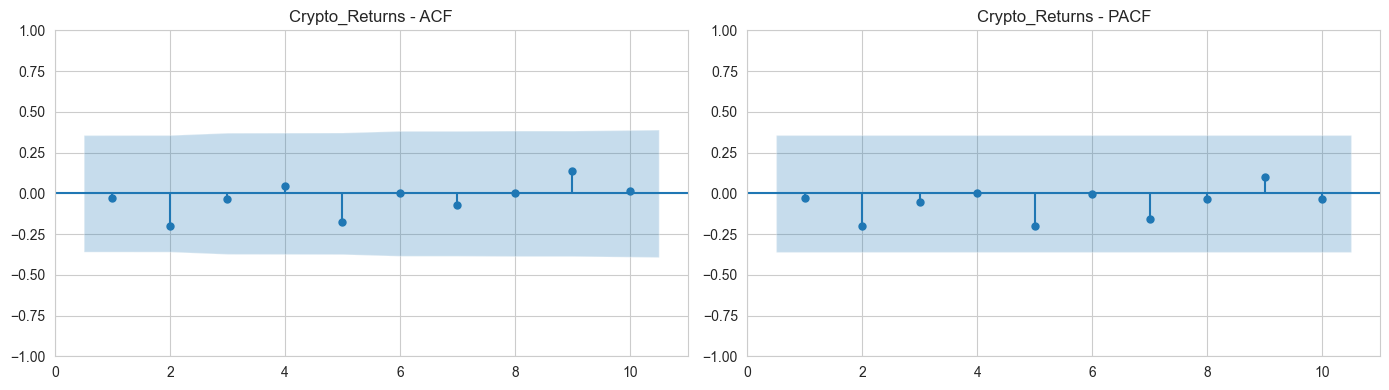


🔍 Đang phân tích: Nexus_Returns


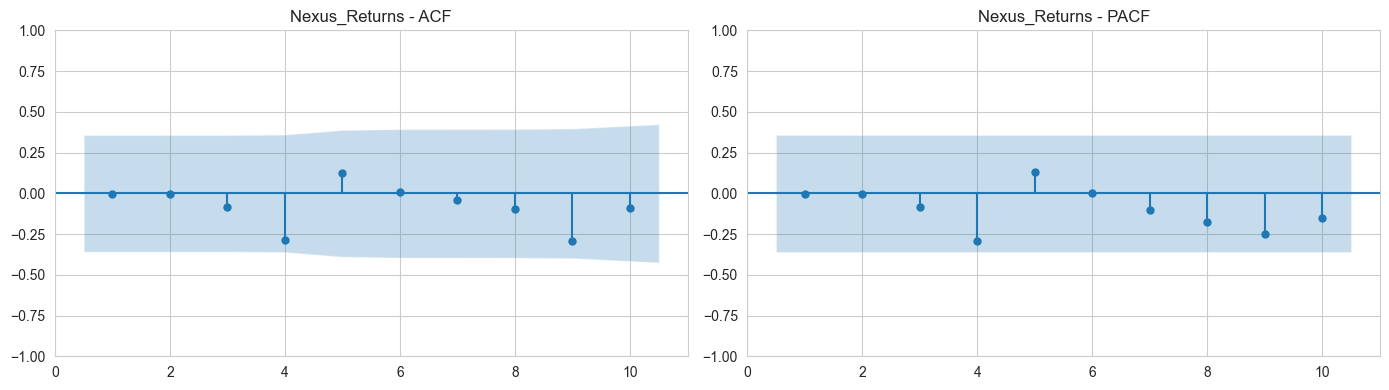


🔍 Đang phân tích: Stocks_Returns


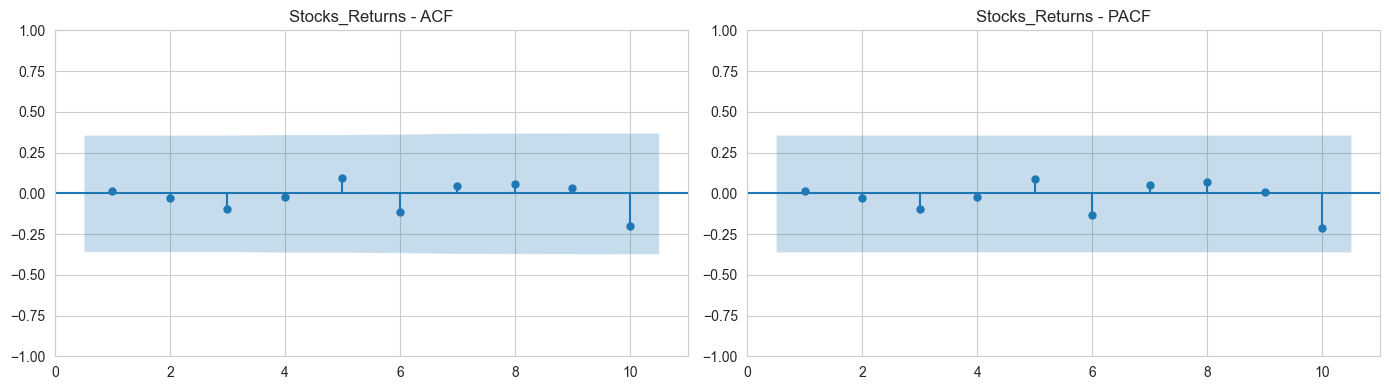

In [21]:
columns_to_plot = ['Crypto_Returns', 'Nexus_Returns', 'Stocks_Returns']

for col in columns_to_plot:
    print(f"\n🔍 Đang phân tích: {col}")
    plot_acf_pacf(residuals_df[col], lags=10, title_prefix=col)

> Ta thấy các lag trên biểu đồ ACF và PACF của cả 3 tài sản đều nằm trong vùng tin cậy (màu xanh), nên tham số tìm từ auto_arima là tham số chuẩn.

## 3.1.2 Xác định Tham số GARCH (p', q')

Để áp dụng mô hình GARCH, đầu tiên phải xem xét
phần dư ước lượng của mô hình ước lượng theo phương
pháp OLS có tồn tại phương sai thay đổi hay không bằng
cách sử dụng kiểm định ARCH-LM.

In [22]:
columns_to_test = ['Crypto_Returns', 'Nexus_Returns', 'Stocks_Returns']
assets_with_arch_effect = []  # Kết quả lưu tại biến này  

print("--- Kết quả kiểm định ARCH-LM ---")

for col in columns_to_test:
    resid_series = residuals_df[col].dropna()
    
    if len(resid_series) < 10:
        print(f"⚠️ Tài sản {col} có quá ít dữ liệu để kiểm định.")
        continue

    test_results = het_arch(resid_series)
    p_value = test_results[1]

    print(f"\n--- Tài sản: {col} ---")
    print(f"P-value của kiểm định ARCH-LM: {p_value:.4f}")

    if p_value < 0.05:
        print("✅ Kết luận: Có hiệu ứng ARCH. Mô hình GARCH là phù hợp.")
        assets_with_arch_effect.append(col)  # Tự động lưu tên asset
    else:
        print("❌ Kết luận: Không có bằng chứng về hiệu ứng ARCH. Mô hình GARCH có thể không cần thiết.")

print("\n--- Các tài sản có hiệu ứng ARCH ---")
print(assets_with_arch_effect)

--- Kết quả kiểm định ARCH-LM ---

--- Tài sản: Crypto_Returns ---
P-value của kiểm định ARCH-LM: 0.2954
❌ Kết luận: Không có bằng chứng về hiệu ứng ARCH. Mô hình GARCH có thể không cần thiết.

--- Tài sản: Nexus_Returns ---
P-value của kiểm định ARCH-LM: 0.6071
❌ Kết luận: Không có bằng chứng về hiệu ứng ARCH. Mô hình GARCH có thể không cần thiết.

--- Tài sản: Stocks_Returns ---
P-value của kiểm định ARCH-LM: 0.9799
❌ Kết luận: Không có bằng chứng về hiệu ứng ARCH. Mô hình GARCH có thể không cần thiết.

--- Các tài sản có hiệu ứng ARCH ---
[]


---
*Ta thấy việc cài đặt mô hình GARCH ở cả 3 loại tài sản đều không thực sự cần thiết cho dữ liệu training 30 ngày đầu tiên. Tuy nhiên điều này có thể thay đổi khi qua các giai đoạn tiếp theo.*

In [23]:
def find_best_garch_params(series, max_p=3, max_q=3):
    """
    Tìm cặp tham số (p', q') tốt nhất cho mô hình GARCH(p', q') - (nếu có) dựa trên AIC.
    """
    best_aic = float('inf')
    best_order = None
    
    for p in range(1, max_p + 1): # p và q của GARCH nên bắt đầu từ 1
        for q in range(max_q + 1):
            if p == 0 and q == 0:
                continue
            try:
                model = arch_model(series, vol='GARCH', p=p, q=q, dist='t') # Thêm dist='t' thường tốt hơn
                result = model.fit(disp='off')
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, q)
            except Exception as e:
                continue

    return best_order

In [24]:
best_garch_orders = {}

print("--- Tìm tham số GARCH tối ưu cho từng tài sản ---")
for asset in assets_with_arch_effect:
    print(f"Đang xử lý: {asset}...")
    
    # Lấy chuỗi phần dư tương ứng
    resid_series = residuals_df[asset].dropna()
    
    # Gọi hàm trên chuỗi phần dư
    best_order = find_best_garch_params(resid_series)
    best_garch_orders[asset] = best_order
    
    print(f"✅ {asset}: Tham số GARCH(p',q') tốt nhất là {best_order}")

print("\n--- Kết quả tổng hợp ---")
print(best_garch_orders)

--- Tìm tham số GARCH tối ưu cho từng tài sản ---

--- Kết quả tổng hợp ---
{}


Do trong dữ liệu của 30 ngày đầu tiên không có tài sản nào vượt qua kiểm định ARCH-LM. Nên ở đây không hiển thị output

## 3.3 Huấn luyện (Fit) mô hình ARIMA(p,d,q) + GARCH(p',q')

In [25]:
# Đảm bảo các hàm này đã được định nghĩa ở các cell trước:
# find_best_garch_params, arima_orders

def fit_all_models(training_df):
    """
    Fit lại tất cả các model, tự động kiểm định ARCH và chọn mô hình
    phù hợp (ARIMA hoặc AR-GARCH) cho từng tài sản dựa trên dữ liệu mới nhất.
    """
    print("   + Đang fit lại các model (có kiểm định ARCH động)...")
    fitted_models = {}
    asset_columns = [col for col in training_df.columns if 'Returns' in col]

    for asset in asset_columns:
        series = training_df[asset].dropna()
        p_arima, d_arima, q_arima = arima_orders[asset]
        
        try:
            # B1: Fit một model ARIMA ban đầu để lấy phần dư
            temp_arima_model = pm.ARIMA(order=(p_arima, d_arima, q_arima)).fit(series)
            residuals = pd.Series(temp_arima_model.resid())

            # B2: Chạy kiểm định ARCH-LM trên phần dư
            p_value = het_arch(residuals)[1]

            # B3: Quyết định mô hình dựa trên p-value
            if p_value < 0.05:
                # Nếu có hiệu ứng ARCH -> Tìm tham số GARCH và fit model AR-GARCH
                print(f"      - {asset}: Phát hiện hiệu ứng ARCH. Chuyển sang AR-GARCH.")
                best_garch_order = find_best_garch_params(residuals)
                
                if best_garch_order:
                    p_garch, q_garch = best_garch_order
                    final_model = arch_model(series, mean='AR', lags=p_arima,
                                             vol='GARCH', p=p_garch, q=q_garch, dist='t')
                    fitted_models[asset] = final_model.fit(disp='off')
                else: # Nếu không tìm được tham số GARCH tốt, quay về ARIMA
                    fitted_models[asset] = temp_arima_model

            else:
                # Nếu không có hiệu ứng ARCH -> Dùng luôn model ARIMA đã fit
                print(f"      - {asset}: Không có hiệu ứng ARCH. Dùng ARIMA.")
                fitted_models[asset] = temp_arima_model
                
        except Exception as e:
            print(f"      Lỗi khi fit model cho {asset}: {e}")
            fitted_models[asset] = None

    print("   + Fit model hoàn tất.")
    return fitted_models

Thử fit các mô hình độc lập ARIMA + GARCH trong dữ liệu training 30 ngày đầu tiên

In [26]:
# Đảm bảo có Các tham số đã định nghĩa trước arima_orders, garch_orders, assets_with_arch_effect
garch_orders = best_garch_orders

# --- TIẾN HÀNH HUẤN LUYỆN ---

all_fitted_models = {} # Dict để lưu tất cả các model đã được huấn luyện

print("--- Bắt đầu huấn luyện mô hình cho từng tài sản ---")
for asset in daily_log_returns.columns:
    if asset == "Selling_Price_of_Nexus" or asset == 'Time':
        continue
    print(f"\nĐang xử lý: {asset}...")
    series = daily_log_returns[asset].dropna()
    
    # Lấy bậc arima tương ứng
    p_arima, d_arima, q_arima = arima_orders[asset]

    try:
        # KIỂM TRA XEM TÀI SẢN CÓ CẦN GARCH KHÔNG
        if asset in assets_with_arch_effect:
            # TRƯỜNG HỢP 1: DÙNG MÔ HÌNH KẾT HỢP AR-GARCH
            p_garch, q_garch = garch_orders[asset]
            
            # Thư viện 'arch' fit mô hình AR-GARCH (không phải ARIMA)
            # Vì d=0, ARIMA(p,0,q) chính là ARMA(p,q)
            # Ở đây ta dùng mô hình AR(p)-GARCH(p',q') là một lựa chọn phổ biến và mạnh mẽ
            model = arch_model(series,
                               mean='AR', lags=p_arima, # Chỉ định phần AR
                               vol='GARCH', p=p_garch, q=q_garch,
                               dist='t') # Phân phối t thường tốt hơn cho tài chính
            
            fitted_model = model.fit(disp='off')
            print(f"✅ {asset}: Fit thành công mô hình AR({p_arima})-GARCH({p_garch},{q_garch})")
            
        else:
            # TRƯỜNG HỢP 2: DÙNG MÔ HÌNH ARIMA ĐƠN GIẢN
            model = pm.ARIMA(order=(p_arima, d_arima, q_arima))
            fitted_model = model.fit(series)
            print(f"✅ {asset}: Fit thành công mô hình ARIMA({p_arima},{d_arima},{q_arima})")

        # Lưu mô hình đã fit vào dict
        all_fitted_models[asset] = fitted_model
        
    except Exception as e:
        print(f"❌ Lỗi khi fit mô hình cho {asset}: {e}")

--- Bắt đầu huấn luyện mô hình cho từng tài sản ---

Đang xử lý: Crypto_Returns...
✅ Crypto_Returns: Fit thành công mô hình ARIMA(0,0,0)

Đang xử lý: Stocks_Returns...
✅ Stocks_Returns: Fit thành công mô hình ARIMA(0,0,0)

Đang xử lý: Nexus_Returns...
✅ Nexus_Returns: Fit thành công mô hình ARIMA(1,1,1)


In [27]:
# Xem kết quả của mô hình 
print("\n--- Kết quả mô hình cho Crypto_Returns ---")
print(all_fitted_models['Crypto_Returns'].summary())

print("\n--- Kết quả mô hình cho Nexus_Returns ---")
print(all_fitted_models['Nexus_Returns'].summary())

print("\n--- Kết quả mô hình cho Stocks_Returns ---")
print(all_fitted_models['Stocks_Returns'].summary())


--- Kết quả mô hình cho Crypto_Returns ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:                        SARIMAX   Log Likelihood                  43.073
Date:                Mon, 28 Jul 2025   AIC                            -82.146
Time:                        15:24:11   BIC                            -79.343
Sample:                             0   HQIC                           -81.249
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0046      0.011     -0.436      0.663      -0.025       0.016
sigma2         0.0033      0.001      5.654      0.000       0.002       0.004
Ljung-Bo

# 4. Mô Phỏng Monte Carlo với ARIMA-GARCH để Ước tính Lợi Nhuận & Rủi Ro Hàng Tháng

Ta cần dùng mô phỏng Monte Carlo trên nhiều lần thử nghiệm để giúp mô hình có khả năng dự đoán chính xác và ít chủ quan hơn.

In [28]:
def simulate_arima_path(arima_model, n_days):
    """
    Hàm này mô phỏng một chuỗi lợi nhuận cho MỘT kịch bản từ MỘT mô hình ARIMA.
    """
    temp_model = copy.deepcopy(arima_model)
    simulated_daily_returns = []

    for _ in range(n_days):
        prediction_result = temp_model.predict(n_periods=1)
        mean_forecast = np.asarray(prediction_result)[0]
        
        # Lấy mảng các tham số từ mô hình
        model_params = temp_model.params()
        
        # SỬA LỖI: Lấy phương sai (sigma2) bằng cách truy cập phần tử CUỐI CÙNG của mảng params.
        error_variance = model_params[-1]
        
        # Đảm bảo phương sai không phải là số âm (rất hiếm nhưng có thể xảy ra do lỗi tối ưu)
        if error_variance < 0:
            error_variance = 0

        random_shock = np.random.normal(loc=0, scale=np.sqrt(error_variance)) # Tạo 1 cú sốc 
        simulated_return_today = mean_forecast + random_shock
        
        simulated_daily_returns.append(simulated_return_today)
        
        temp_model.update(simulated_return_today)
        
    return simulated_daily_returns

In [29]:
def run_monte_carlo_simulation(all_fitted_models, n_simulations=5000, n_days=30):
    """
    Hàm mô phỏng chính, gọi các hàm con tương ứng với từng loại model.
    """
    assets = list(all_fitted_models.keys())
    all_monthly_returns = []

    print(f"🚀 Bắt đầu {n_simulations} kịch bản mô phỏng cho {n_days} ngày tới...")

    # Vòng lặp cho mỗi kịch bản (ví dụ: 100 lần)
    for _ in tqdm(range(n_simulations), desc="Đang mô phỏng"):
        
        # Dict để lưu tổng lợi nhuận tháng của kịch bản này
        path_total_returns = {}

        # Lặp qua từng tài sản (Crypto, Stock, Nexus)
        for asset in assets:
            model = all_fitted_models[asset]
            
            # Khởi tạo một chuỗi rỗng cho kịch bản của tài sản này
            simulated_path = []

            # KIỂM TRA LOẠI MODEL VÀ GỌI HÀM MÔ PHỎNG TƯƠNG ỨNG
            if isinstance(model, pm.arima.ARIMA):
                # Nếu là ARIMA, gọi hàm phụ ta vừa tạo ở trên
                simulated_path = simulate_arima_path(model, n_days)
                
            elif isinstance(model, ARCHModelResult):
                # Nếu là GARCH, dùng phương thức forecast có sẵn
                forecasts = model.forecast(horizon=n_days, method='simulation', simulations=1)
                simulated_path = forecasts.simulations.values[0, :, 0]
            
            else:
                raise TypeError(f"Loại model của tài sản {asset} không được hỗ trợ.")

            # Tính tổng lợi nhuận của kịch bản này và lưu lại
            path_total_returns[asset] = np.sum(simulated_path)

        all_monthly_returns.append(path_total_returns)

    # --- Tổng hợp kết quả ---
    results_df = pd.DataFrame(all_monthly_returns)
    monthly_mu = results_df.mean()
    monthly_S = results_df.cov()
    
    print("\n✅ Mô phỏng hoàn tất!")
    return monthly_mu, monthly_S

In [30]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

# Bỏ qua các cảnh báo về hội tụ và chỉ số
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ValueWarning)

print("Các cảnh báo đã được tắt.")

Các cảnh báo đã được tắt.


### Giải thích bỏ qua các cảnh báo
Nếu không bỏ qua thì có thể sẽ có các cảnh báo sau:

* **ValueWarning**: Cảnh báo vô hại, chỉ báo rằng index kết quả dự báo là số nguyên thay vì ngày tháng. Điều này bình thường và đã được xử lý trong code.
* **ConvergenceWarning**: Là cảnh báo chính. Trong mô phỏng Monte Carlo (`simulate_arima_path`), do tạo ra các cú sốc ngẫu nhiên lớn, mô hình đôi khi khó hội tụ. Đây là đặc trưng tự nhiên của mô phỏng.

Ta sẽ bỏ qua vì

* Có thể bỏ qua an toàn.
* Các cảnh báo này xuất hiện rải rác, không ảnh hưởng đến kết quả cuối như kỳ vọng lợi nhuận (`mu`) hay ma trận rủi ro (`S`) do sai số được trung bình hóa qua nhiều chuỗi mô phỏng.


In [31]:
# Chạy mô phỏng để kiểm tra - lưu ý ở đây mô phỏng 10 trường hợp để demo kết quả chứ không dùng để tính toán 
# Montecarlo cần rất nhiều trường hợp để mô phỏng mang ý nghĩa thống kê 
monthly_mu, monthly_S = run_monte_carlo_simulation(
    all_fitted_models=all_fitted_models,
    n_simulations=10,
    n_days=10
)

# Hiển thị kết quả
print("\n--- Vector Lợi nhuận Kỳ vọng Hàng tháng (μ) ---")
print(monthly_mu)
print("\n--- Ma trận Hiệp phương sai Hàng tháng (S) ---")
print(monthly_S)

🚀 Bắt đầu 10 kịch bản mô phỏng cho 10 ngày tới...


Đang mô phỏng: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


✅ Mô phỏng hoàn tất!

--- Vector Lợi nhuận Kỳ vọng Hàng tháng (μ) ---
Crypto_Returns    0.073699
Stocks_Returns   -0.042971
Nexus_Returns    -0.051564
dtype: float64

--- Ma trận Hiệp phương sai Hàng tháng (S) ---
                Crypto_Returns  Stocks_Returns  Nexus_Returns
Crypto_Returns        0.044656        0.002550       0.000989
Stocks_Returns        0.002550        0.002355       0.000404
Nexus_Returns         0.000989        0.000404       0.001022


In [32]:
# --- Hiển thị kết quả để xác nhận ---
print("✅ Đã tạo lại các tham số thành công!")
print("\n--- Vector Lợi nhuận Kỳ vọng Hàng tháng (μ) ---")
print(monthly_mu)
print("\n--- Ma trận Hiệp phương sai Hàng tháng (S) ---")
print(monthly_S)

✅ Đã tạo lại các tham số thành công!

--- Vector Lợi nhuận Kỳ vọng Hàng tháng (μ) ---
Crypto_Returns    0.073699
Stocks_Returns   -0.042971
Nexus_Returns    -0.051564
dtype: float64

--- Ma trận Hiệp phương sai Hàng tháng (S) ---
                Crypto_Returns  Stocks_Returns  Nexus_Returns
Crypto_Returns        0.044656        0.002550       0.000989
Stocks_Returns        0.002550        0.002355       0.000404
Nexus_Returns         0.000989        0.000404       0.001022


# 5. Tối ưu hóa Danh mục & Tìm tỷ trọng tối ưu bằng Markovist

## 5.1 Thêm gửi tiết kiệm vào trong danh mục

In [33]:
# Lợi nhuận kỳ vọng hàng tháng của tiết kiệm
tiet_kiem_mu = 0.075 / 12

# Thêm vào vector mu
# Giả sử tên là 'Tiet_Kiem'
mu_4_assets = pd.concat([monthly_mu, pd.Series({'Tiet_Kiem': tiet_kiem_mu})])


# Mở rộng ma trận S thành 4x4
# Tạo một DataFrame 4x4 với giá trị 0
S_4_assets = pd.DataFrame(np.zeros((4, 4)),
                          index=mu_4_assets.index,
                          columns=mu_4_assets.index)

# Chép các giá trị cũ của ma trận 3x3 vào
S_4_assets.iloc[:3, :3] = monthly_S
num_assets = 4

print("--- Vector Lợi nhuận kỳ vọng 4 tài sản ---")
print(mu_4_assets)
print("\n--- Ma trận Hiệp phương sai 4 tài sản ---")
print(S_4_assets)

--- Vector Lợi nhuận kỳ vọng 4 tài sản ---
Crypto_Returns    0.073699
Stocks_Returns   -0.042971
Nexus_Returns    -0.051564
Tiet_Kiem         0.006250
dtype: float64

--- Ma trận Hiệp phương sai 4 tài sản ---
                Crypto_Returns  Stocks_Returns  Nexus_Returns  Tiet_Kiem
Crypto_Returns        0.044656        0.002550       0.000989        0.0
Stocks_Returns        0.002550        0.002355       0.000404        0.0
Nexus_Returns         0.000989        0.000404       0.001022        0.0
Tiet_Kiem             0.000000        0.000000       0.000000        0.0


## 5.2 Cài đặt mô hình Markovist

Để để mô hình tập trung vào các xu hướng gần đây và trở nên linh hoạt hơn ta sẽ sử dụng "cửa sổ trượt" (rolling window) thay vì "cửa sổ mở rộng" (expanding window)

In [34]:
# --- Thiết lập và chạy tối ưu hóa ---
RISK_FREE_RATE = 0.075 / 12
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

def portfolio_performance(weights, mu, S):
    p_return = np.sum(mu * weights)
    p_volatility = np.sqrt(np.dot(weights.T, np.dot(S, weights)))
    return p_return, p_volatility

def negative_sharpe_ratio(weights, mu, S, risk_free_rate):
    p_return, p_volatility = portfolio_performance(weights, mu, S)
    if p_volatility == 0: return np.inf
    return -(p_return - risk_free_rate) / p_volatility

In [35]:
# CÁC HÀM CẦN THIẾT (TỪ CÁC BƯỚC TRƯỚC)
# fit_all_models, simulate_arima_path, run_monte_carlo_simulation, portfolio_performance, negative_sharpe_ratio

# --- BẮT ĐẦU QUÁ TRÌNH BACKTEST CHO 4 TÀI SẢN ---

### THÊM SIÊU THAM SỐ MỚI ###
TRAINING_WINDOW_DAYS = 30 # Chỉ dùng 60 ngày dữ liệu gần nhất để training

days_in_month = 30
n_months_to_backtest = test_day // days_in_month
all_optimal_weights = []
asset_names_4 = []

# Dữ liệu training ban đầu
rolling_training_data = daily_log_returns.copy()

# Lãi suất tiết kiệm hàng tháng
tiet_kiem_mu = 0.075 / 12

print("="*50)
print(f"🚀 Bắt đầu Backtest với cửa sổ trượt {TRAINING_WINDOW_DAYS} ngày...")
print("="*50)

for i in range(n_months_to_backtest):
    print(f"\n--- Đang xử lý Tháng {i+1}/{n_months_to_backtest} ---")
    
    # 1. Fit lại model cho 3 tài sản rủi ro
    all_fitted_models = fit_all_models(rolling_training_data)
    
    # 2. Chạy mô phỏng Monte Carlo
    print(f"   + Đang chạy Monte Carlo cho Tháng {i+1}...")
    mu_risky, S_risky = run_monte_carlo_simulation(
        all_fitted_models=all_fitted_models,
        n_simulations=100,
        n_days=days_in_month
    )

    # 3. "Ghép" tài sản tiết kiệm vào kết quả mô phỏng
    mu_4_assets = pd.concat([mu_risky, pd.Series({'Tiet_Kiem': tiet_kiem_mu})])
    asset_names_4 = mu_4_assets.index
    
    S_4_assets = pd.DataFrame(np.zeros((4, 4)), index=asset_names_4, columns=asset_names_4)
    S_4_assets.iloc[:3, :3] = S_risky

    # 4. Chạy tối ưu hóa Markowitz
    print(f"   + Đang tối ưu hóa cho Tháng {i+1}...")
    num_assets = 4
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    initial_weights = np.array(num_assets * [1. / num_assets,])
    args = (mu_4_assets, S_4_assets, RISK_FREE_RATE)
    
    optimal_result = minimize(fun=negative_sharpe_ratio, x0=initial_weights, args=args,
                              method='SLSQP', bounds=bounds, constraints=constraints)
    
    # 5. Lưu lại tỷ trọng tối ưu
    current_weights = optimal_result.x
    all_optimal_weights.append(current_weights)
    print(f"✅ Hoàn tất xử lý cho Tháng {i+1}.")

    # 6. Cập nhật dữ liệu training cho tháng tiếp theo
    print("   + Đang cập nhật dữ liệu cho vòng lặp sau...")
    start_index = i * days_in_month
    end_index = (i + 1) * days_in_month
    
    new_data_from_test = daily_log_returns_test.iloc[start_index:end_index]
    
    ### CẬP NHẬT LOGIC CỬA SỔ TRƯỢT ###
    # Nối dữ liệu mới vào
    combined_data = pd.concat([rolling_training_data, new_data_from_test])
    
    # Cắt lại DataFrame để chỉ giữ lại N ngày gần nhất
    rolling_training_data = combined_data.tail(TRAINING_WINDOW_DAYS)
    print(f"   + Dữ liệu training được cập nhật. Kích thước mới: {len(rolling_training_data)} dòng.")
    

# --- TỔNG HỢP KẾT QUẢ ---
print("\n\n--- Backtest hoàn tất! ---")
backtest_allocation_df = pd.DataFrame(
    all_optimal_weights,
    columns=asset_names_4,
    index=[f'Tháng {i+1}' for i in range(n_months_to_backtest)]
)

print("\n--- Bảng phân bổ tỷ trọng tự động qua 3 tháng ---")
print(backtest_allocation_df)

🚀 Bắt đầu Backtest với cửa sổ trượt 30 ngày...

--- Đang xử lý Tháng 1/11 ---
   + Đang fit lại các model (có kiểm định ARCH động)...
      - Crypto_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Stocks_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Nexus_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
   + Fit model hoàn tất.
   + Đang chạy Monte Carlo cho Tháng 1...
🚀 Bắt đầu 100 kịch bản mô phỏng cho 30 ngày tới...


Đang mô phỏng: 100%|██████████| 100/100 [02:42<00:00,  1.63s/it]



✅ Mô phỏng hoàn tất!
   + Đang tối ưu hóa cho Tháng 1...
✅ Hoàn tất xử lý cho Tháng 1.
   + Đang cập nhật dữ liệu cho vòng lặp sau...
   + Dữ liệu training được cập nhật. Kích thước mới: 30 dòng.

--- Đang xử lý Tháng 2/11 ---
   + Đang fit lại các model (có kiểm định ARCH động)...
      - Crypto_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Stocks_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Nexus_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
   + Fit model hoàn tất.
   + Đang chạy Monte Carlo cho Tháng 2...
🚀 Bắt đầu 100 kịch bản mô phỏng cho 30 ngày tới...


Đang mô phỏng: 100%|██████████| 100/100 [02:25<00:00,  1.45s/it]



✅ Mô phỏng hoàn tất!
   + Đang tối ưu hóa cho Tháng 2...
✅ Hoàn tất xử lý cho Tháng 2.
   + Đang cập nhật dữ liệu cho vòng lặp sau...
   + Dữ liệu training được cập nhật. Kích thước mới: 30 dòng.

--- Đang xử lý Tháng 3/11 ---
   + Đang fit lại các model (có kiểm định ARCH động)...
      - Crypto_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Stocks_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Nexus_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
   + Fit model hoàn tất.
   + Đang chạy Monte Carlo cho Tháng 3...
🚀 Bắt đầu 100 kịch bản mô phỏng cho 30 ngày tới...


Đang mô phỏng: 100%|██████████| 100/100 [03:10<00:00,  1.90s/it]



✅ Mô phỏng hoàn tất!
   + Đang tối ưu hóa cho Tháng 3...
✅ Hoàn tất xử lý cho Tháng 3.
   + Đang cập nhật dữ liệu cho vòng lặp sau...
   + Dữ liệu training được cập nhật. Kích thước mới: 30 dòng.

--- Đang xử lý Tháng 4/11 ---
   + Đang fit lại các model (có kiểm định ARCH động)...
      - Crypto_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Stocks_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Nexus_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
   + Fit model hoàn tất.
   + Đang chạy Monte Carlo cho Tháng 4...
🚀 Bắt đầu 100 kịch bản mô phỏng cho 30 ngày tới...


Đang mô phỏng: 100%|██████████| 100/100 [03:25<00:00,  2.06s/it]



✅ Mô phỏng hoàn tất!
   + Đang tối ưu hóa cho Tháng 4...
✅ Hoàn tất xử lý cho Tháng 4.
   + Đang cập nhật dữ liệu cho vòng lặp sau...
   + Dữ liệu training được cập nhật. Kích thước mới: 30 dòng.

--- Đang xử lý Tháng 5/11 ---
   + Đang fit lại các model (có kiểm định ARCH động)...
      - Crypto_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Stocks_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Nexus_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
   + Fit model hoàn tất.
   + Đang chạy Monte Carlo cho Tháng 5...
🚀 Bắt đầu 100 kịch bản mô phỏng cho 30 ngày tới...


Đang mô phỏng: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]



✅ Mô phỏng hoàn tất!
   + Đang tối ưu hóa cho Tháng 5...
✅ Hoàn tất xử lý cho Tháng 5.
   + Đang cập nhật dữ liệu cho vòng lặp sau...
   + Dữ liệu training được cập nhật. Kích thước mới: 30 dòng.

--- Đang xử lý Tháng 6/11 ---
   + Đang fit lại các model (có kiểm định ARCH động)...
      - Crypto_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Stocks_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Nexus_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
   + Fit model hoàn tất.
   + Đang chạy Monte Carlo cho Tháng 6...
🚀 Bắt đầu 100 kịch bản mô phỏng cho 30 ngày tới...


Đang mô phỏng: 100%|██████████| 100/100 [02:08<00:00,  1.28s/it]



✅ Mô phỏng hoàn tất!
   + Đang tối ưu hóa cho Tháng 6...
✅ Hoàn tất xử lý cho Tháng 6.
   + Đang cập nhật dữ liệu cho vòng lặp sau...
   + Dữ liệu training được cập nhật. Kích thước mới: 30 dòng.

--- Đang xử lý Tháng 7/11 ---
   + Đang fit lại các model (có kiểm định ARCH động)...
      - Crypto_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Stocks_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Nexus_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
   + Fit model hoàn tất.
   + Đang chạy Monte Carlo cho Tháng 7...
🚀 Bắt đầu 100 kịch bản mô phỏng cho 30 ngày tới...


Đang mô phỏng: 100%|██████████| 100/100 [02:28<00:00,  1.49s/it]



✅ Mô phỏng hoàn tất!
   + Đang tối ưu hóa cho Tháng 7...
✅ Hoàn tất xử lý cho Tháng 7.
   + Đang cập nhật dữ liệu cho vòng lặp sau...
   + Dữ liệu training được cập nhật. Kích thước mới: 30 dòng.

--- Đang xử lý Tháng 8/11 ---
   + Đang fit lại các model (có kiểm định ARCH động)...
      - Crypto_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Stocks_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Nexus_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
   + Fit model hoàn tất.
   + Đang chạy Monte Carlo cho Tháng 8...
🚀 Bắt đầu 100 kịch bản mô phỏng cho 30 ngày tới...


Đang mô phỏng: 100%|██████████| 100/100 [03:20<00:00,  2.00s/it]



✅ Mô phỏng hoàn tất!
   + Đang tối ưu hóa cho Tháng 8...
✅ Hoàn tất xử lý cho Tháng 8.
   + Đang cập nhật dữ liệu cho vòng lặp sau...
   + Dữ liệu training được cập nhật. Kích thước mới: 30 dòng.

--- Đang xử lý Tháng 9/11 ---
   + Đang fit lại các model (có kiểm định ARCH động)...
      - Crypto_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Stocks_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Nexus_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
   + Fit model hoàn tất.
   + Đang chạy Monte Carlo cho Tháng 9...
🚀 Bắt đầu 100 kịch bản mô phỏng cho 30 ngày tới...


Đang mô phỏng: 100%|██████████| 100/100 [02:43<00:00,  1.64s/it]



✅ Mô phỏng hoàn tất!
   + Đang tối ưu hóa cho Tháng 9...
✅ Hoàn tất xử lý cho Tháng 9.
   + Đang cập nhật dữ liệu cho vòng lặp sau...
   + Dữ liệu training được cập nhật. Kích thước mới: 30 dòng.

--- Đang xử lý Tháng 10/11 ---
   + Đang fit lại các model (có kiểm định ARCH động)...
      - Crypto_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Stocks_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Nexus_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
   + Fit model hoàn tất.
   + Đang chạy Monte Carlo cho Tháng 10...
🚀 Bắt đầu 100 kịch bản mô phỏng cho 30 ngày tới...


Đang mô phỏng: 100%|██████████| 100/100 [02:28<00:00,  1.48s/it]



✅ Mô phỏng hoàn tất!
   + Đang tối ưu hóa cho Tháng 10...
✅ Hoàn tất xử lý cho Tháng 10.
   + Đang cập nhật dữ liệu cho vòng lặp sau...
   + Dữ liệu training được cập nhật. Kích thước mới: 30 dòng.

--- Đang xử lý Tháng 11/11 ---
   + Đang fit lại các model (có kiểm định ARCH động)...
      - Crypto_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Stocks_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
      - Nexus_Returns: Không có hiệu ứng ARCH. Dùng ARIMA.
   + Fit model hoàn tất.
   + Đang chạy Monte Carlo cho Tháng 11...
🚀 Bắt đầu 100 kịch bản mô phỏng cho 30 ngày tới...


Đang mô phỏng: 100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


✅ Mô phỏng hoàn tất!
   + Đang tối ưu hóa cho Tháng 11...
✅ Hoàn tất xử lý cho Tháng 11.
   + Đang cập nhật dữ liệu cho vòng lặp sau...
   + Dữ liệu training được cập nhật. Kích thước mới: 30 dòng.


--- Backtest hoàn tất! ---

--- Bảng phân bổ tỷ trọng tự động qua 3 tháng ---
          Crypto_Returns  Stocks_Returns  Nexus_Returns     Tiet_Kiem
Tháng 1     1.000000e+00    0.000000e+00   0.000000e+00  1.110223e-16
Tháng 2     5.559428e-01    3.111299e-01   1.329273e-01  5.421011e-20
Tháng 3     7.730331e-02    8.251537e-01   9.740542e-02  1.375811e-04
Tháng 4     1.000000e+00    0.000000e+00   7.494005e-16  0.000000e+00
Tháng 5     0.000000e+00    9.618181e-01   3.434698e-02  3.834872e-03
Tháng 6     5.584422e-14    1.000000e+00   5.218048e-15  7.549517e-15
Tháng 7     0.000000e+00    9.143501e-01   0.000000e+00  8.564992e-02
Tháng 8     8.291338e-01    3.469447e-17   0.000000e+00  1.708662e-01
Tháng 9     0.000000e+00    3.792577e-01   5.505603e-01  7.018208e-02
Tháng 10    0.000000e

## 5.3 Cơ cấu danh mục đầu tư qua các tháng

Biểu đồ đã được lưu với tên portfolio_allocation.png


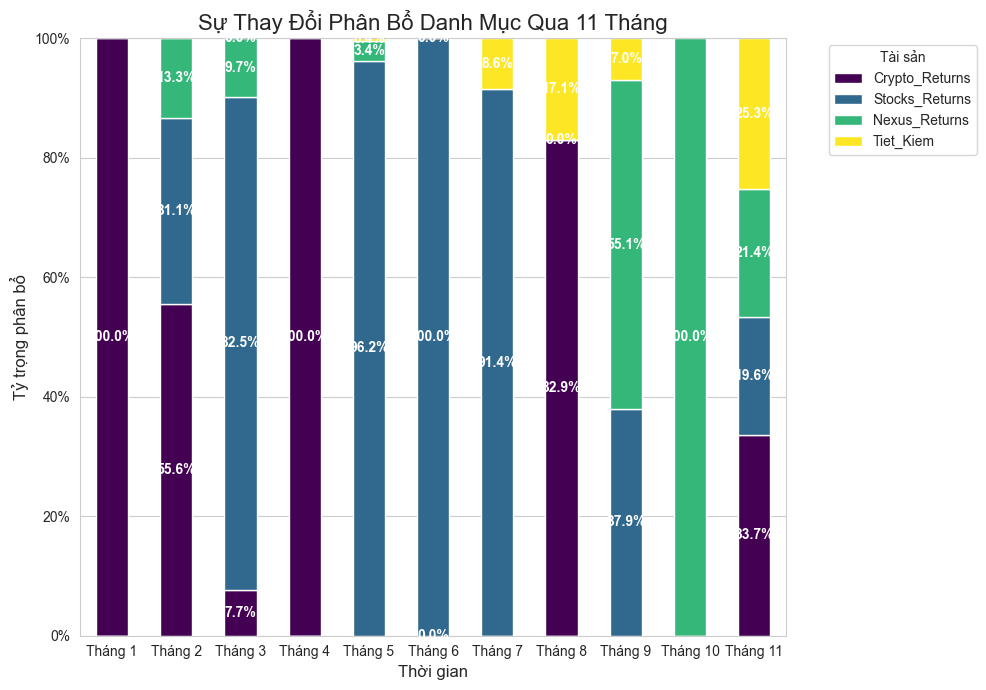

In [36]:
# Vẽ biểu đồ
ax = backtest_allocation_df.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 7),
    cmap='viridis', # Bảng màu
    rot=0 # Xoay nhãn trục x
)

# --- Định dạng biểu đồ cho đẹp hơn ---
ax.set_title(f'Sự Thay Đổi Phân Bổ Danh Mục Qua {n_months_to_backtest} Tháng', fontsize=16)
ax.set_ylabel('Tỷ trọng phân bổ', fontsize=12)
ax.set_xlabel('Thời gian', fontsize=12)
ax.legend(title='Tài sản', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # Định dạng trục y là %

# Thêm nhãn giá trị (tỷ lệ %) vào từng phần của cột
for c in ax.containers:
    labels = [f'{w*100:,.1f}%' for w in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', color='white', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("portfolio_allocation.png")
print("Biểu đồ đã được lưu với tên portfolio_allocation.png")

# 6. Mô phỏng giá trị danh mục qua các tháng

## 6.1 Chuẩn bị các siêu tham số cho quá trình mô phỏng

In [37]:
# --- Dữ liệu đầu vào ---
# Bảng phân bổ tỷ trọng tối ưu qua 3 tháng
allocation_data = {
    col: backtest_allocation_df[col].tolist()
    for col in backtest_allocation_df.columns
}

index_labels = [f'Tháng {i+1}' for i in range(n_months_to_backtest)]
backtest_allocation_df = pd.DataFrame(allocation_data, index=index_labels)

# Các tham số ban đầu
initial_capital = 100000
days_in_month = 30 # Backtest đang chạy với 30 ngày/tháng
n_months = test_day//days_in_month 
tiet_kiem_mu_monthly = 0.075 / 12

print("--- Bảng phân bổ tỷ trọng sẽ sử dụng ---")
print(backtest_allocation_df)

--- Bảng phân bổ tỷ trọng sẽ sử dụng ---
          Crypto_Returns  Stocks_Returns  Nexus_Returns     Tiet_Kiem
Tháng 1     1.000000e+00    0.000000e+00   0.000000e+00  1.110223e-16
Tháng 2     5.559428e-01    3.111299e-01   1.329273e-01  5.421011e-20
Tháng 3     7.730331e-02    8.251537e-01   9.740542e-02  1.375811e-04
Tháng 4     1.000000e+00    0.000000e+00   7.494005e-16  0.000000e+00
Tháng 5     0.000000e+00    9.618181e-01   3.434698e-02  3.834872e-03
Tháng 6     5.584422e-14    1.000000e+00   5.218048e-15  7.549517e-15
Tháng 7     0.000000e+00    9.143501e-01   0.000000e+00  8.564992e-02
Tháng 8     8.291338e-01    3.469447e-17   0.000000e+00  1.708662e-01
Tháng 9     0.000000e+00    3.792577e-01   5.505603e-01  7.018208e-02
Tháng 10    0.000000e+00    2.109424e-15   1.000000e+00  0.000000e+00
Tháng 11    3.366998e-01    1.960008e-01   2.143781e-01  2.529213e-01


## 6.2 Áp dụng chiến lược tối ưu hóa chốt lời/ cắt lỗ phù hợp 

Logic hiện tại đang đặt mức chốt lời (TP) và cắt lỗ (SL) bằng nhau, dựa trên độ biến động (volatility). Điều này có nghĩa là tỷ lệ Risk/Reward (R/R) đang là 1:1.
Để an toàn hơn, chúng ta cần một tỷ lệ R/R tốt hơn, ví dụ như 1:2 hoặc 1:3. Tức là, bạn chấp nhận rủi ro mất 1 đồng để có cơ hội kiếm được 2 hoặc 3 đồng.

  * **Cắt lỗ sớm:** Giới hạn mức lỗ ở một khoảng nhỏ hơn so với biến động tự nhiên của tài sản.
  * **Chốt lời muộn hơn:** Cho phép tài sản có đủ không gian để tăng trưởng và chỉ chốt lời khi đạt được một mức lợi nhuận đáng kể.

**Cách thực hiện:** Chúng ta sẽ sử dụng chính `volatility` đã tính toán làm một "thước đo" cơ bản. Sau đó, ta sẽ nhân nó với các **hệ số điều chỉnh** để tạo ra các mức TP/SL bất đối xứng.

  * `Mức cắt lỗ = volatility * HỆ_SỐ_CẮT_LỖ` (ví dụ: hệ số 0.5 để cắt lỗ sớm hơn)
  * `Mức chốt lời = volatility * HỆ_SỐ_CHỐT_LỜI` (ví dụ: hệ số 1.5 để chốt lời muộn hơn)

In [38]:
### THÊM SIÊU THAM SỐ MỚI ĐỂ ĐIỀU CHỈNH TỶ LỆ R/R ###
TAKE_PROFIT_MULTIPLIER = 1.5  # Mức chốt lời = 1.5 lần độ biến động
STOP_LOSS_MULTIPLIER = 0.5   # Mức cắt lỗ = 0.5 lần độ biến động
                             # -> Tỷ lệ R/R mục tiêu là 1:3 (0.5 so với 1.5)

def calculate_dynamic_tpsl(training_data, risky_assets):
    """
    Tính toán mức TP/SL linh động với các hệ số điều chỉnh bất đối xứng.
    """
    trading_days_per_year = {
        'Crypto_Returns': 365,
        'Stocks_Returns': 252,
        'Nexus_Returns': 252
    }
    
    daily_volatility = training_data[risky_assets].std()
    
    take_profit_levels = {}
    stop_loss_levels = {}
    
    for asset in risky_assets:
        sqrt_trading_days = np.sqrt(trading_days_per_year[asset])
        annualized_volatility = daily_volatility[asset] * sqrt_trading_days
        
        # Áp dụng hệ số điều chỉnh
        take_profit_levels[asset] = annualized_volatility * TAKE_PROFIT_MULTIPLIER
        stop_loss_levels[asset] = annualized_volatility * STOP_LOSS_MULTIPLIER
        
    return take_profit_levels, stop_loss_levels

Để mô phỏng tiền tiết kiệm chỉ được rút vào cuối kì hạn, chúng ta cần một nơi để giữ số tiền bán được giữa kỳ. Giải pháp là tạo ra một tài khoản thứ năm gọi là **"Cash" (Tiền mặt)**.

1.  **`Tiet_Kiem`**: Sẽ được phân bổ vốn vào **đầu tháng** và bị **khóa**. Giá trị của nó không thay đổi trong suốt 30 ngày.
2.  **`Cash`**: Sẽ bắt đầu bằng 0 vào đầu mỗi tháng. Nó sẽ là nơi **nhận tiền** khi một tài sản rủi ro được bán do chốt lời/cắt lỗ. Số tiền này sẽ được giữ ở đó cho đến kỳ tái cân bằng tiếp theo.
3.  **Lãi suất `Tiet_Kiem`**: Sẽ được tính dựa trên số vốn **ban đầu** đã gửi vào đầu tháng.

In [39]:
# Phí giao dịch (giữ nguyên)
TRANSACTION_FEES = {
    'Crypto_Returns': 0.001,
    'Stocks_Returns': 0.0015,
    'Nexus_Returns': avg_transaction_cost_nexus
}

print("🚀 Đang mô phỏng chiến lược (TP/SL linh động theo Volatility)...")

# --- Thiết lập ---
risky_assets = ['Crypto_Returns', 'Stocks_Returns', 'Nexus_Returns']
all_asset_names = risky_assets + ['Tiet_Kiem', 'Cash']
current_capital = initial_capital
daily_history_list = []
trade_log = []
total_fees_paid = 0
previous_asset_values = pd.Series(0, index=all_asset_names)
previous_asset_values['Cash'] = initial_capital

# Lặp qua từng tháng
for i in range(n_months):
    weights = backtest_allocation_df.iloc[i]
    
    # TÍNH TOÁN TP/SL LINH ĐỘNG VÀO ĐẦU MỖI THÁNG
    TAKE_PROFIT_LEVELS, STOP_LOSS_LEVELS = calculate_dynamic_tpsl(rolling_training_data, risky_assets)
    
    print(f"\n--- Tháng {i+1}: Các mức TP/SL bất đối xứng được cập nhật ---")
    for asset in risky_assets:
        print(f"  - {asset.replace('_Returns', '')}: TP: {TAKE_PROFIT_LEVELS[asset]:.2%}, SL: {STOP_LOSS_LEVELS[asset]:.2%}")

    # --- TÍNH PHÍ GIAO DỊCH KHI TÁI CÂN BẰNG ---
    # (Phần còn lại của code giữ nguyên y hệt như trước)
    target_values = current_capital * weights
    trade_values = (target_values - previous_asset_values).abs()
    rebalancing_fees = 0
    for asset in risky_assets:
        rebalancing_fees += trade_values.get(asset, 0) * TRANSACTION_FEES.get(asset, 0)
    
    current_capital -= rebalancing_fees
    total_fees_paid += rebalancing_fees
    print(f"   + Phí tái cân bằng: {rebalancing_fees:,.2f}")

    # Phân bổ vốn sau khi đã trừ phí
    asset_values = pd.Series(current_capital * weights)
    if 'Cash' not in asset_values.index: asset_values['Cash'] = 0.0
    asset_values = asset_values.reindex(all_asset_names, fill_value=0.0)

    initial_month_values = asset_values.copy()
    triggered_assets = {asset: False for asset in risky_assets}
    
    start_index = i * days_in_month
    end_index = (i + 1) * days_in_month
    month_data = daily_log_returns_test.iloc[start_index:end_index]
    
    # Lặp qua từng ngày trong tháng
    for day_index, row in month_data.iterrows():
        # Cập nhật giá trị
        for asset in risky_assets:
            if not triggered_assets[asset] and pd.notna(row[asset]):
                asset_values[asset] *= np.exp(row[asset])

        # Kiểm tra TP/SL với các mức linh động
        for asset in risky_assets:
            if not triggered_assets[asset] and initial_month_values[asset] > 0:
                pnl_percent = (asset_values[asset] - initial_month_values[asset]) / initial_month_values[asset]
                
                ### THAY ĐỔI 2: Lấy mức TP/SL riêng của từng tài sản ###
                tp_level = TAKE_PROFIT_LEVELS.get(asset)
                sl_level = STOP_LOSS_LEVELS.get(asset)
                
                if pnl_percent >= tp_level or pnl_percent <= -sl_level:
                    event = "CHỐT LỜI" if pnl_percent > 0 else "CẮT LỖ"
                    date_of_event = row['Time'].date()
                    sale_value = asset_values[asset]
                    fee = sale_value * TRANSACTION_FEES.get(asset, 0)
                    total_fees_paid += fee
                    log_entry = (f"Ngày {str(date_of_event)}: {event} {asset} ({pnl_percent*100:+.2f}%). "
                                 f"Giá trị bán: {sale_value:,.2f}, Phí: {fee:,.2f}")
                    trade_log.append(log_entry)
                    asset_values['Cash'] += sale_value - fee
                    asset_values[asset] = 0
                    triggered_assets[asset] = True
        
        daily_snapshot = asset_values.copy()
        daily_snapshot['Date'] = row['Time']
        daily_history_list.append(daily_snapshot)

    previous_asset_values = asset_values.copy()
    capital_at_month_end = asset_values.sum()
    lai_tiet_kiem = initial_month_values['Tiet_Kiem'] * tiet_kiem_mu_monthly
    current_capital = capital_at_month_end + lai_tiet_kiem

# --- In ra nhật ký giao dịch và tổng hợp ---
print("\n" + "="*50)
print("               NHẬT KÝ GIAO DỊCH")
print("="*50)
if trade_log:
    for entry in trade_log:
        print(entry)
else:
    print("Không có giao dịch chốt lời/cắt lỗ nào được thực hiện.")

dynamic_portfolio_history = pd.DataFrame(daily_history_list).set_index('Date')
dynamic_portfolio_history['Total_Value'] = dynamic_portfolio_history.sum(axis=1)

print("\n✅ Mô phỏng hoàn tất!")
print(f"Tổng phí giao dịch đã trả: {total_fees_paid:,.2f}")

🚀 Đang mô phỏng chiến lược (TP/SL linh động theo Volatility)...

--- Tháng 1: Các mức TP/SL bất đối xứng được cập nhật ---
  - Crypto: TP: 76.06%, SL: 25.35%
  - Stocks: TP: 50.88%, SL: 16.96%
  - Nexus: TP: 11.98%, SL: 3.99%
   + Phí tái cân bằng: 100.00

--- Tháng 2: Các mức TP/SL bất đối xứng được cập nhật ---
  - Crypto: TP: 76.06%, SL: 25.35%
  - Stocks: TP: 50.88%, SL: 16.96%
  - Nexus: TP: 11.98%, SL: 3.99%
   + Phí tái cân bằng: 217.41

--- Tháng 3: Các mức TP/SL bất đối xứng được cập nhật ---
  - Crypto: TP: 76.06%, SL: 25.35%
  - Stocks: TP: 50.88%, SL: 16.96%
  - Nexus: TP: 11.98%, SL: 3.99%
   + Phí tái cân bằng: 274.80

--- Tháng 4: Các mức TP/SL bất đối xứng được cập nhật ---
  - Crypto: TP: 76.06%, SL: 25.35%
  - Stocks: TP: 50.88%, SL: 16.96%
  - Nexus: TP: 11.98%, SL: 3.99%
   + Phí tái cân bằng: 535.04

--- Tháng 5: Các mức TP/SL bất đối xứng được cập nhật ---
  - Crypto: TP: 76.06%, SL: 25.35%
  - Stocks: TP: 50.88%, SL: 16.96%
  - Nexus: TP: 11.98%, SL: 3.99%
   + P

In [40]:
dynamic_portfolio_history

,Crypto_Returns,Stocks_Returns,Nexus_Returns,Tiet_Kiem,Cash,Total_Value
Date,,,,,,
2024-06-20,103714.305660,0.000000,0.000000,1.109113e-11,0.0,103714.305660
2024-06-21,103748.171393,0.000000,0.000000,1.109113e-11,0.0,103748.171393
2024-06-22,108277.929455,0.000000,0.000000,1.109113e-11,0.0,108277.929455
2024-06-23,107392.284182,0.000000,0.000000,1.109113e-11,0.0,107392.284182
2024-06-24,106587.389196,0.000000,0.000000,1.109113e-11,0.0,106587.389196
...,...,...,...,...,...,...
2025-05-11,40190.562239,27018.156106,31693.310543,3.571570e+04,0.0,134617.728956
2025-05-12,40901.190935,26384.206368,31827.990063,3.571570e+04,0.0,134829.087434
2025-05-13,40772.318372,26651.493332,31839.418161,3.571570e+04,0.0,134978.929933


## 6.3 So sánh với một chiến lược đầu tư đơn giản

Để xác định xem chiến lược tối ưu hóa có thực sự hiệu quả không, ta sẽ mô phỏng một chiến lược đơn giản(ta sẽ so sánh nó với một chiến lược cơ sở). Ở đây, ta sẽ dùng chiến lược "Mua và Giữ" (Buy and Hold) với tỷ trọng chia đều cho 3 tài sản rủi ro.

In [41]:
print("📊 Đang mô phỏng chiến lược so sánh (Buy and Hold)...")
risky_asset_names = ['Crypto_Returns', 'Stocks_Returns', 'Nexus_Returns']

# Phân bổ đều vốn ban đầu cho 3 tài sản rủi ro
initial_benchmark_allocations = (initial_capital / 3) * pd.Series([1,1,1], index=risky_asset_names)

# Lấy dữ liệu của 90 ngày
benchmark_period_data = daily_log_returns_test.head(n_months * days_in_month)

# Tính hệ số tăng trưởng cộng dồn trong 90 ngày
benchmark_cumulative_growth = np.exp(benchmark_period_data[risky_asset_names].cumsum())

# Tính giá trị danh mục từng ngày
benchmark_history = initial_benchmark_allocations * benchmark_cumulative_growth

# SỬA LỖI: Gán lại index của benchmark_history thành ngày tháng để khớp với
# dynamic_portfolio_history.
benchmark_history.index = benchmark_period_data['Time']

# Tính tổng giá trị
benchmark_history['Total_Value'] = benchmark_history.sum(axis=1)

print("✅ Mô phỏng chiến lược so sánh hoàn tất!")

📊 Đang mô phỏng chiến lược so sánh (Buy and Hold)...
✅ Mô phỏng chiến lược so sánh hoàn tất!


In [42]:
results_df = pd.DataFrame({
    'Dynamic_Strategy': dynamic_portfolio_history['Total_Value'],
    'Buy_and_Hold_Benchmark': benchmark_history['Total_Value']
})

# Lấy giá trị cuối cùng
final_value_dynamic = results_df['Dynamic_Strategy'].iloc[-1]
final_value_benchmark = results_df['Buy_and_Hold_Benchmark'].iloc[-1]

# Tính toán Lời/Lỗ
pnl_dynamic = final_value_dynamic - initial_capital
pnl_benchmark = final_value_benchmark - initial_capital

# Tính % tăng trưởng
g_dynamic = (pnl_dynamic / initial_capital) * 100
g_benchmark = (pnl_benchmark / initial_capital) * 100

print("="*50)
print(f"     KẾT QUẢ SAU {n_months_to_backtest} THÁNG ĐẦU TƯ")
print("="*50)

print("\n--- Chiến lược Tối ưu hóa (Dynamic Strategy) ---")
print(f"Giá trị cuối cùng : {final_value_dynamic:,.2f}")
print(f"Lời/Lỗ            : {pnl_dynamic:,.2f} ({g_dynamic:.2f}%)")

print("\n--- Chiến lược Mua và Giữ (Benchmark) ---")
print(f"Giá trị cuối cùng : {final_value_benchmark:,.2f}")
print(f"Lời/Lỗ            : {pnl_benchmark:,.2f} ({g_benchmark:.2f}%)")

print("\n--- Nhận xét ---")
if pnl_dynamic > pnl_benchmark:
    print("🏆 Chúc mừng! Chiến lược của bạn đã hoạt động hiệu quả hơn so với chiến lược mua và giữ đơn giản.")
else:
    print("🤔 Chiến lược của bạn chưa hiệu quả bằng. Cần xem xét lại các tham số hoặc mô hình.")

     KẾT QUẢ SAU 11 THÁNG ĐẦU TƯ

--- Chiến lược Tối ưu hóa (Dynamic Strategy) ---
Giá trị cuối cùng : 136,306.48
Lời/Lỗ            : 36,306.48 (36.31%)

--- Chiến lược Mua và Giữ (Benchmark) ---
Giá trị cuối cùng : 129,732.22
Lời/Lỗ            : 29,732.22 (29.73%)

--- Nhận xét ---
🏆 Chúc mừng! Chiến lược của bạn đã hoạt động hiệu quả hơn so với chiến lược mua và giữ đơn giản.



Biểu đồ so sánh hiệu suất đã được lưu với tên performance_comparison.png


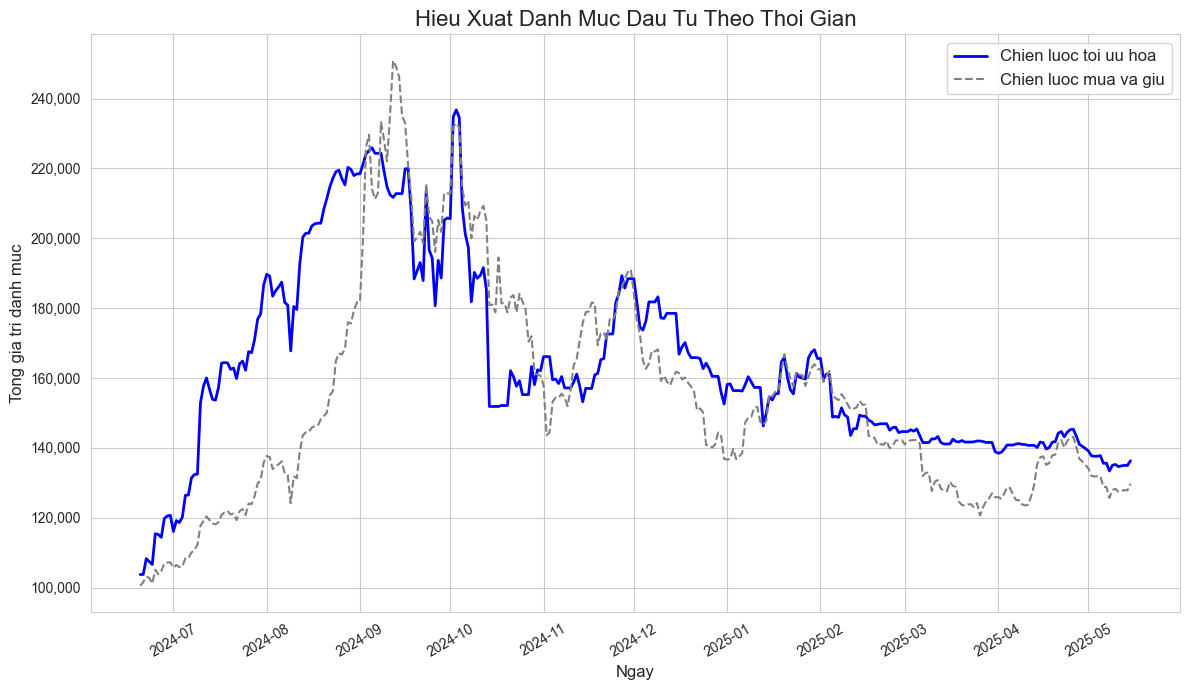

In [43]:
fig, ax = plt.subplots(figsize=(12, 7))

# Vẽ đường biểu diễn giá trị của 2 danh mục
ax.plot(results_df.index, results_df['Dynamic_Strategy'], label='Chien luoc toi uu hoa', color='blue', linewidth=2)
ax.plot(results_df.index, results_df['Buy_and_Hold_Benchmark'], label='Chien luoc mua va giu', color='gray', linestyle='--')

# Định dạng biểu đồ
ax.set_title('Hieu Xuat Danh Muc Dau Tu Theo Thoi Gian', fontsize=16)
ax.set_ylabel('Tong gia tri danh muc', fontsize=12)
ax.set_xlabel('Ngay', fontsize=12)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.legend(fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()

# Lưu biểu đồ
plt.savefig("performance_comparison.png")
print("\nBiểu đồ so sánh hiệu suất đã được lưu với tên performance_comparison.png")

## 6.4 Cơ cấu đóng góp của các loại tài sản qua từng giai đoạn

📊 Đang tạo biểu đồ chi tiết hiệu suất từng tài sản...

✅ Biểu đồ chi tiết đã được lưu với tên individual_asset_performance.png


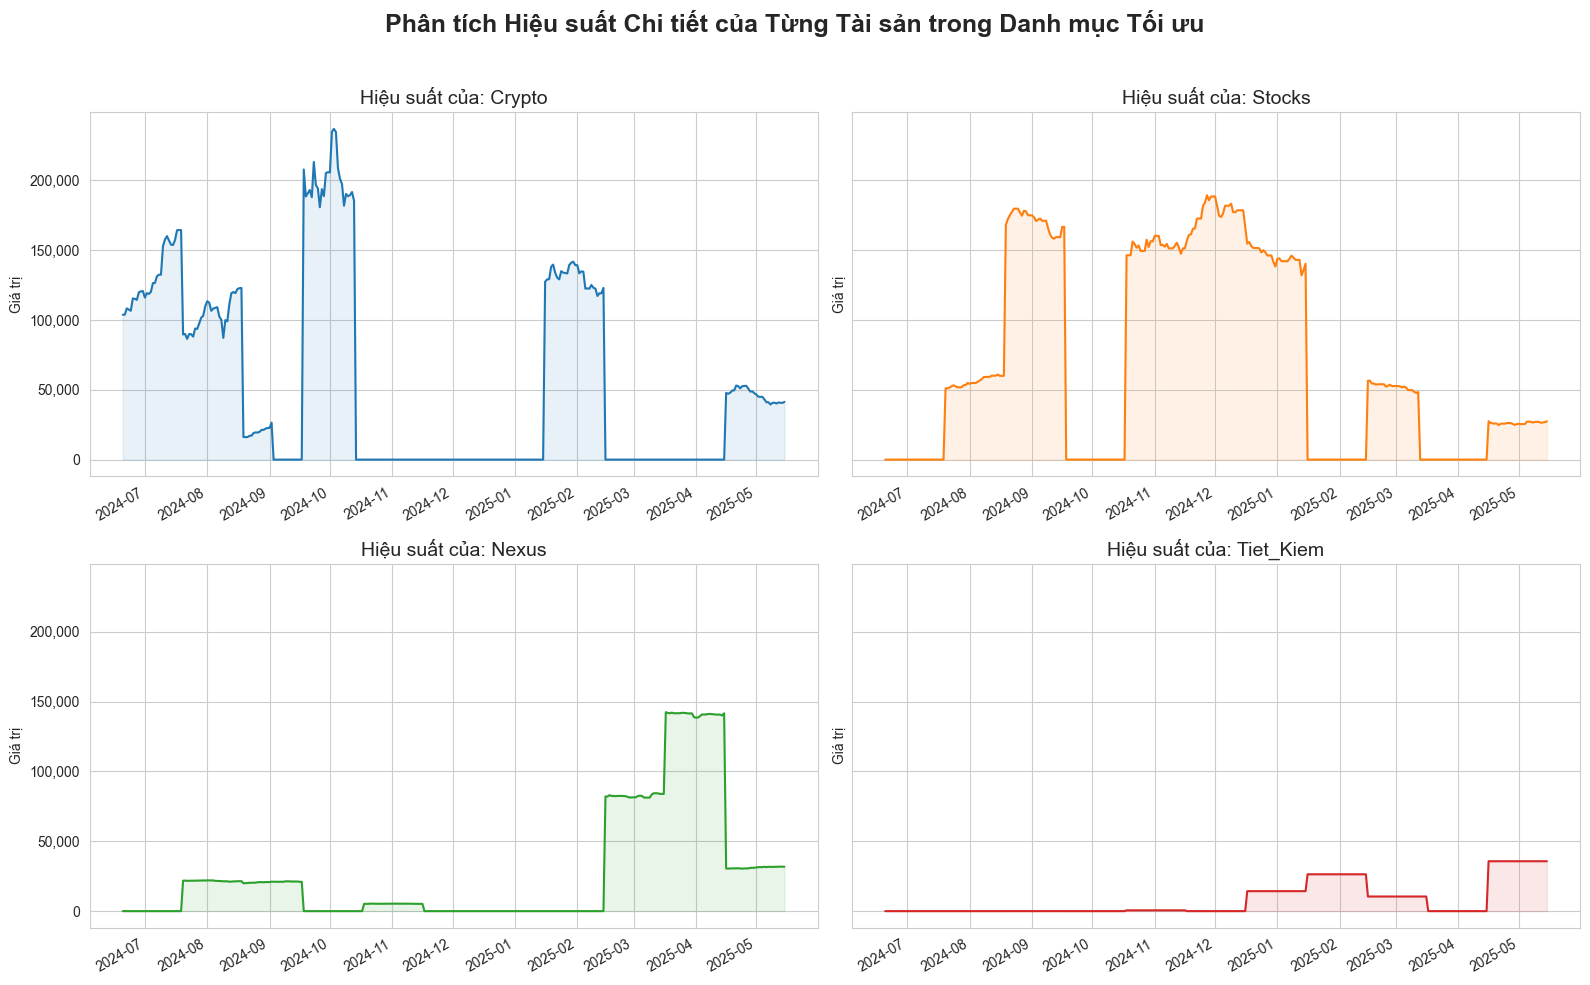

In [44]:
# --- Thiết lập ---
# Danh sách các tài sản muốn xem chi tiết
assets_to_plot = ['Crypto_Returns', 'Stocks_Returns', 'Nexus_Returns', 'Tiet_Kiem']

# Tạo một lưới biểu đồ 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10), sharey=True)

# "Làm phẳng" mảng axes để dễ lặp
axes = axes.flatten()

print("📊 Đang tạo biểu đồ chi tiết hiệu suất từng tài sản...")

# --- Lặp qua từng tài sản và vẽ biểu đồ tương ứng ---
for i, asset in enumerate(assets_to_plot):
    ax = axes[i]
    
    # Lấy dữ liệu của tài sản và vẽ đường biểu diễn giá trị
    asset_data = dynamic_portfolio_history[asset]
    ax.plot(asset_data.index, asset_data, color=f'C{i}')
    
    # Lấp đầy vùng dưới đường line để dễ nhìn hơn
    ax.fill_between(asset_data.index, asset_data, alpha=0.1, color=f'C{i}')
    
    # --- Định dạng cho từng biểu đồ con ---
    # Bỏ đi phần "_Returns" trong tên cho gọn
    clean_asset_name = asset.replace("_Returns", "")
    ax.set_title(f"Hiệu suất của: {clean_asset_name}", fontsize=14)
    ax.set_ylabel("Giá trị", fontsize=10)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # Xoay nhãn ngày tháng
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')

# --- Định dạng chung cho cả hình ---
fig.suptitle('Phân tích Hiệu suất Chi tiết của Từng Tài sản trong Danh mục Tối ưu', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Điều chỉnh để tiêu đề chung không bị đè

# Lưu biểu đồ
plt.savefig("individual_asset_performance.png")
print("\n✅ Biểu đồ chi tiết đã được lưu với tên individual_asset_performance.png")

plt.show()

###### 